# Performing parameter studies with PINNs in TorchPhysics: Example 7
We now consider the Stokes equation and want to learn the flow field for different injection angles $\alpha$. The equation is given by:

\begin{align*}
    -\frac{\mu}{2} \text{div}(\nabla u_\alpha + \nabla u_\alpha^T) + \nabla p_\alpha &= 0 &&\text{ in } [0, 1]^2, \text{(Conservation of momentum)}, \\
    \text{div}(u_\alpha) &= 0 &&\text{ in } [0, 1]^2,  \text{(Conservation of mass)}, \\
    u_\alpha &= u_{in}(\alpha, x) , &&\text{ on } \{0 \} \times [0, 1], \text{(Inflow condition)}\\
    u_\alpha &= 0 , &&\text{ on } [0, 1] \times \{0, 1\}, \text{(Noslip condition)} \\
    -\frac{\mu}{2}(\nabla u_\alpha + \nabla u_\alpha^T) \cdot n + p_\alpha n &= 0 , &&\text{ on }  \{1 \} \times [0, 1], \text{(Outflow condition)}.
\end{align*}

This equation describes a channel, where at the left side we prescribe the velocity field, at the bottom and top have a noslip condition (where the fluid sticks to the wall) and at the right side a free outflow. You dont need to understand what each equation means in detail, some further information will be given below.

Our main goal is to learn, with one single neural network, multiple solutions for different $\alpha$. 

The inflow function will be given by
\begin{equation*}
    u_{in}(\alpha, x) = 4.0 x_2 (1.0 - x_2) \left(\begin{matrix}\cos(\alpha) \\ \sin(\alpha)\end{matrix} \right),
\end{equation*}
such that the flow direction is controlled by the angle and the velocity profile reaches 0 when we approach the bottom and top boundary. 

In [1]:
import pathlib
import os
gpu_device = str(int(str(pathlib.Path().resolve())[-2:]) % 7)
os.environ["CUDA_VISIBLE_DEVICES"]= gpu_device

     |████████████████████████████████| 797.1 MB 111.2 MB/s eta 0:00:01^C


In [2]:
import torch
import torchphysics as tp
import pytorch_lightning as pl
import math

# Here all parameters are defined:
h, w = 1, 1
mu = 0.5
speed_scale = 4.0

# Number of training points 
N_pde = 80000
N_in = 40000
N_out = 10000

First we need define the spaces of our problem. Note, we now need a space "X" for the domain, "A" for the inflow angles, "u" for the velocity output and "p" for the pressure!

Next ot the domain $\Omega$, we also need to sample different angles that will be used as an input to our neural network and in the inflow function.
For now, create the interval $[\pi/4.0, \pi/2.0]$ for our angles.

In [3]:
# TODO: Add the space for pressure and velocity
X = tp.spaces.R2('x')
A = tp.spaces.R1("alpha")
P = tp.spaces.R1('p')
U = tp.spaces.R2('u')

Omega = tp.domains.Parallelogram(X, [0, 0], [w, 0], [0, h])
# TODO: Create interval for the angles (use math.pi, for pi):
A_int = tp.domains.Interval(A, math.pi/4.0, math.pi/2.0)

Next are the samplers, which are almost complete. We again need to filter the points at the boundary, since we have multiple boundary conditions.
Here, we incoperate the Dirichlet conditions into one PINN-condition and therefore need only two samplers.

Finish the sampler that returns true if the point $x$ is on the right boundary, meaning $x_1 = 1$.

In [4]:
# TODO: Complete the filter function:
def right_boundary_filter(x):
    return x[:, :1] == w

def other_boundary_filter(x):
    return torch.logical_not(right_boundary_filter(x))

inner_sampler = tp.samplers.RandomUniformSampler(Omega*A_int, N_pde)
dirichlet_boundary_sampler = tp.samplers.RandomUniformSampler(A_int*Omega.boundary, N_in, filter_fn=other_boundary_filter)
outflow_boundary_sampler = tp.samplers.RandomUniformSampler(A_int*Omega.boundary, N_out, filter_fn=right_boundary_filter)

In the following cell, we prepared the inflow function:

In [5]:
def inflow_fn(x, alpha):
    inflow_fn = torch.ones_like(x)
    inflow_fn *= speed_scale * x[:, 1:] * (h - x[:, 1:])
    inflow_fn[:, :1] *= torch.cos(alpha) 
    inflow_fn[:, 1:] *= torch.sin(alpha) 
    return inflow_fn

Now, we can start with implementing all conditions. Lets start with the neural network, that should learn the solution consisting of $(u, p)$ for different $(x, \alpha)$.

In [16]:
# TODO: Add the correct input and output spaces
model = tp.models.FCN(input_space=X*A, output_space=U*P, hidden=(50, 50, 50, 50))

The first condition, will be the conservation of mass meaning $\text{div}(u)=0$:

In [17]:
# TODO: Implement the residual and complete the PINNCondition.
# Use tp.utils.div to compute the divergence of a vector field
def mass_residual(u, x):
    return tp.utils.div(u, x)

mass_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=mass_residual, weight=20.0)

The second condition, is the conservation of momentum meaning $-\frac{\mu}{2} \text{div}(\nabla u + \nabla u^T) + \nabla p=0$:


In [18]:
def momentum_residual(u, p, x):
    sym_grad = tp.utils.sym_grad(u, x) # <- already contains the factor 1/2
    mat_div = tp.utils.matrix_div(sym_grad, x)
    p_grad = tp.utils.grad(p, x)
    # TODO: Add the return for the momentum residual
    return - mu * mat_div + p_grad

momentum_condition = tp.conditions.PINNCondition(module=model, sampler=inner_sampler, residual_fn=momentum_residual)

Now, we need to handle the boundary conditions. Let start with the Dirichlet condition.
As mentioned before we can combine the inflow and noslip condition into one, since the inflow is also 0 at the top and bottom. Our sampler is also already build to sampler points from the need boundary.

In [19]:
# TODO: finish the residual for the Dirichlet condition.
# Note, we already prepared the inflow function a few cells back. If you use the function
# the residual only consists of 2 line of code.
def dirichlet_residual(u, x, alpha):
    inflow = inflow_fn(x, alpha)
    return u - inflow

# TODO: Use a PINNCondition with a weight of 50.0!
dirichlet_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=dirichlet_boundary_sampler,
                                            residual_fn=dirichlet_residual, weight=50.0)

Lastly the outflow condition, which we already finished for you:

In [20]:
def outflow_residual(u, p, x):
    n = Omega.boundary.normal(x)
    sym_grad = tp.utils.sym_grad(u, x)
    res = - mu * torch.bmm(sym_grad, n.unsqueeze(-1)).squeeze(-1) + p*n
    return res

outflow_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=outflow_boundary_sampler,
                                            residual_fn=outflow_residual)

We can now start the training:

In [21]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=1e-3)
# TODO: Collect all for conditions we previously created:
solver = tp.solver.Solver([dirichlet_condition, mass_condition, momentum_condition, outflow_condition],
                           optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=1000, 
                     logger=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 8.0 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: User

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

To obtain better results, we switch to LBFGS. This optimizer is a bit slower but has a better convergence behaviour for this problem.

In [22]:
mass_condition.sampler = mass_condition.sampler.make_static()
momentum_condition.sampler = momentum_condition.sampler.make_static()
dirichlet_condition.sampler = dirichlet_condition.sampler.make_static()
outflow_condition.sampler = outflow_condition.sampler.make_static()


optim = tp.OptimizerSetting(torch.optim.LBFGS, lr=0.1, optimizer_args={"max_iter" : 5})
solver = tp.solver.Solver([dirichlet_condition, mass_condition, momentum_condition, outflow_condition],
                           optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=400, 
                     logger=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 8.0 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

We could train even more to further improve the results. But let us check the solution now:

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)


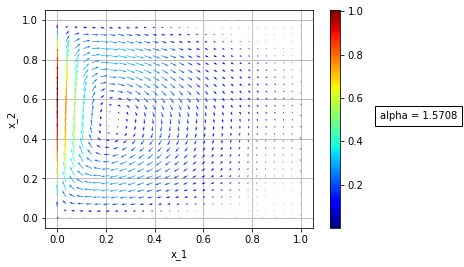

In [14]:
# TODO: The following value will be used as the inflow value. Play around with the value 
# to see different solutions.
# Note, we only trained for values in [pi/4, pi/2]. What happens if you but in values outside this range?
alpha_eval = math.pi/2.0

Omega_plot = tp.domains.Parallelogram(X, [0, 0], [1, 0], [0, 1])
plot_sampler = tp.samplers.PlotSampler(Omega_plot, 800, data_for_other_variables={"alpha": alpha_eval})

fig = tp.utils.plot(model, lambda u: u, plot_sampler)

We can also plot the pressure profile we have learned:

/home/tomfre/Desktop/torchphysics/src/torchphysics/utils/plotting/plot_functions.py:416: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  embed_point = Points(torch.tensor([center]), domain.space)


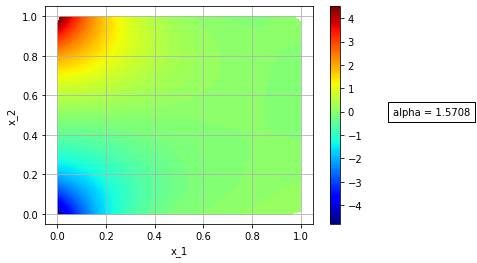

In [15]:
Omega_plot = tp.domains.Parallelogram(X, [0, 0], [1, 0], [0, 1])
plot_sampler = tp.samplers.PlotSampler(Omega_plot, 800, data_for_other_variables={"alpha": alpha_eval})

fig = tp.utils.plot(model, lambda p: p, plot_sampler, plot_type="contour_surface")

Or even create a animation of the solution over multiple inflow angles:

In [ ]:
anim_sampler = tp.samplers.AnimationSampler(Omega, A_int, 80, n_points=800)
fig, anim = tp.utils.animate(model, lambda u: u, anim_sampler, ani_speed=5)
anim.save('flow.gif')
# On Google colab you have at the left side a tab with a folder. There you can find the gif and can watch it.

In [ ]:
import numpy as np
# Note: Here, we assumed that the input space is in order X*A. If you have it ordered differently
# just call us we can quickly modify it for you!

# Get data from Github:
!wget https://github.com/TomF98/torchphysics/raw/Berlin-Workshop/examples/SolutionData/StokesData/coords.npy
!wget https://github.com/TomF98/torchphysics/raw/Berlin-Workshop/examples/SolutionData/StokesData/flow_0.npy
!wget https://github.com/TomF98/torchphysics/raw/Berlin-Workshop/examples/SolutionData/StokesData/flow_1.npy
!wget https://github.com/TomF98/torchphysics/raw/Berlin-Workshop/examples/SolutionData/StokesData/flow_2.npy

# Read data:
coords = torch.tensor(np.load("coords.npy"), dtype=torch.float32).reshape(-1, 2)
sol_1 = torch.tensor(np.load("flow_0.npy"), dtype=torch.float32).reshape(-1, 2)
sol_2 = torch.tensor(np.load("flow_1.npy"), dtype=torch.float32).reshape(-1, 2)
sol_3 = torch.tensor(np.load("flow_2.npy"), dtype=torch.float32).reshape(-1, 2)

angle_list = [math.pi/4.0, math.pi/3.0, math.pi/2.0]
sol_list = [sol_1, sol_2, sol_3]
error = 0
for angle, current_sol in zip(angle_list, sol_list):
    # Build input
    in_points = torch.zeros((len(sol_1), 3))
    in_points[:, :2] = coords
    in_points[:, 2] = angle

    # Evaluate Network:
    model_out = model(tp.spaces.Points(in_points, X*A)).as_tensor

    current_error = model_out[:, :2] - current_sol
    error = max(error, torch.max(torch.abs(current_error)))

print("Relative difference to FEM in Sup-norm:")
print(error)